
# Import the necessary libraries for our analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import confusion_matrix

# Load the data from the different files

In [2]:
# Load the data
patient = pd.read_csv('/Volumes/Samsung USB/CombinedData/combined1.csv')
allergies = pd.read_csv('/Volumes/Samsung USB/synthea_1m_fhir_3_0_May_24/output_1/csv/allergies.csv')
immunizations = pd.read_csv('/Volumes/Samsung USB/synthea_1m_fhir_3_0_May_24/output_1/csv/immunizations.csv')
conditions = pd.read_csv('/Volumes/Samsung USB/synthea_1m_fhir_3_0_May_24/output_1/csv/conditions.csv')
medications = pd.read_csv('/Volumes/Samsung USB/synthea_1m_fhir_3_0_May_24/output_1/csv/medications.csv')
encounters = pd.read_csv('/Volumes/Samsung USB/synthea_1m_fhir_3_0_May_24/output_1/csv/encounters.csv')
careplans = pd.read_csv('/Volumes/Samsung USB/synthea_1m_fhir_3_0_May_24/output_1/csv/careplans.csv')

# In this cell, we will be dropping unnecessary columns from the loaded datasets.



In [3]:
patient.drop(columns=['CONDITIONS_CODE','MEDICATIONS_CODE','MEDICATIONS_REASONCODE','ENCOUNTERS_CODE','ENCOUNTERS_REASONCODE','ALLERGIES_CODE', 'IMMUNIZATIONS_CODE', 'CAREPLANS_CODE', 'CAREPLANS_REASONCODE', 'OBSERVATIONS_CODE'], inplace=True)
conditions.drop(columns=['START', 'STOP', 'ENCOUNTER', 'DESCRIPTION'], inplace=True)
medications.drop(columns=['START', 'STOP', 'ENCOUNTER', 'DESCRIPTION', 'REASONDESCRIPTION'], inplace=True)
immunizations.drop(columns=['DATE', 'ENCOUNTER', 'DESCRIPTION'], inplace=True)
allergies.drop(columns=['START', 'STOP', 'ENCOUNTER', 'DESCRIPTION'], inplace=True)
encounters.drop(columns=['DATE', 'ID', 'DESCRIPTION', 'REASONDESCRIPTION'], inplace=True)
careplans.drop(columns=['ID', 'START', 'STOP', 'ENCOUNTER', 'DESCRIPTION', 'REASONDESCRIPTION'], inplace=True)

# In this cell, we are filling missing values in certain columns with the mode of the respective column.


In [4]:
columns_to_fill_with_mode = ['RACE', 'ETHNICITY', 'GENDER', 'BIRTHPLACE', 'ZIP']
for column in columns_to_fill_with_mode:
    mode_value = patient[column].mode()[0]
    patient[column].fillna(mode_value, inplace=True)

In [5]:
patient['MARITAL'] = patient['MARITAL'].fillna('S')

In [6]:
patient['DEATHDATE'] = patient['DEATHDATE'].apply(lambda x: str(x).lower() != 'false')


In [7]:
patient['BIRTHDATE'] = pd.to_datetime(patient['BIRTHDATE'], errors='coerce')
patient = patient.dropna(subset=['BIRTHDATE'])
reference_date = pd.to_datetime('2023-01-01')
patient['AGE'] = (reference_date - patient['BIRTHDATE']).dt.days // 365.25

In [8]:
patient['DEATHDATE'] = pd.to_datetime(patient['DEATHDATE'], errors='coerce')
patient['AGE_AT_DEATH'] = (patient['DEATHDATE'] - patient['BIRTHDATE']).dt.days // 365.25
patient['AGE_AT_DEATH'] = patient['AGE_AT_DEATH'].fillna(0)

In [9]:
patient['MARITAL'] = patient['MARITAL'].apply(lambda x: 0 if x == 'S' else 1)
patient['GENDER'] = patient['GENDER'].apply(lambda x: 0 if x == 'F' else 1)

In [10]:
label_encoder = LabelEncoder()
categorical_columns = ['RACE', 'ETHNICITY', 'BIRTHPLACE', 'ZIP']
for column in categorical_columns:
    patient[column] = label_encoder.fit_transform(patient[column])

/Users/dakariantoine/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/dakariantoine/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/dakariantoine/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/dakariantoine/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseD

In [11]:
# Define the lung cancer codes
lung_cancer_codes = [162573006, 254637007, 423121009, 424132000, 422968005, 254632001, 67821000119109]

# Create a boolean column in the conditions dataframe that is True for lung cancer conditions
conditions['is_lung_cancer'] = conditions['CODE'].isin(lung_cancer_codes)

# Create a list of patient IDs that have lung cancer
lung_cancer_patient_ids = conditions[conditions['is_lung_cancer']]['PATIENT'].unique()

# Create a target variable in the patient dataframe that is 1 for patients with lung cancer and 0 for patients without lung cancer
patient['has_lung_cancer'] = patient['Id'].isin(lung_cancer_patient_ids).astype(int) if 'Id' in patient.columns else np.zeros(len(patient), dtype=int)


In [12]:
# Define the new feature columns
feature_columns = ['AGE','AGE_AT_DEATH','PASSPORT','MARITAL','RACE','ETHNICITY','GENDER','BIRTHPLACE','ZIP','BODY_WEIGHT','BODY_HEIGHT','BMI','SYSTOLIC_BP','DIASTOLIC_BP']

# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(patient[feature_columns], patient['has_lung_cancer'], test_size=0.2, random_state=42)

In [13]:
# Create an XGBoost classifier
clf = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Convert the 'PASSPORT' column to int type before training the classifier
# Handle non-numeric values in 'PASSPORT' column
X_train['PASSPORT'] = pd.to_numeric(X_train['PASSPORT'], errors='coerce').fillna(0).astype(int)
X_test['PASSPORT'] = pd.to_numeric(X_test['PASSPORT'], errors='coerce').fillna(0).astype(int)

# Train the classifier
clf.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [14]:
# Make predictions on the test set
y_pred = clf.predict(X_test)

# Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred)

# Print the accuracy
print(f"Accuracy: {accuracy}")

# Print the confusion matrix
print(confusion_matrix(y_test, y_pred))

# Print the classification report
print(classification_report(y_test, y_pred))

Accuracy: 1.0
[[20909]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     20909

    accuracy                           1.00     20909
   macro avg       1.00      1.00      1.00     20909
weighted avg       1.00      1.00      1.00     20909



/Users/dakariantoine/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/dakariantoine/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/dakariantoine/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/dakariantoine/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseD

/Users/dakariantoine/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/dakariantoine/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/dakariantoine/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/dakariantoine/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseD

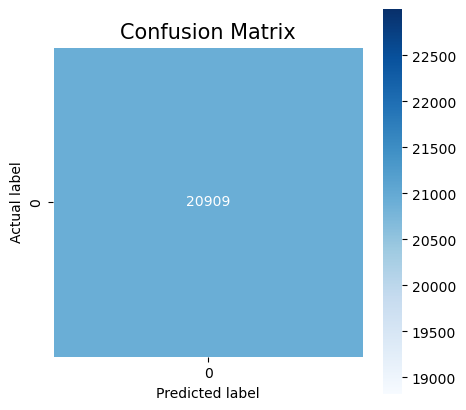

In [15]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create a heatmap
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
plt.title('Confusion Matrix', size = 15);
plt.show()

In [16]:
print(np.unique(y_pred))

[0]


In [17]:
# Plot feature importance
try:
    plot_importance(clf)
    plt.show()
except ValueError as ve:
    print("Error while plotting feature importance: ", ve)


Error while plotting feature importance:  Booster.get_score() results in empty.  This maybe caused by having all trees as decision dumps.


/Users/dakariantoine/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/dakariantoine/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/dakariantoine/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/dakariantoine/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseD

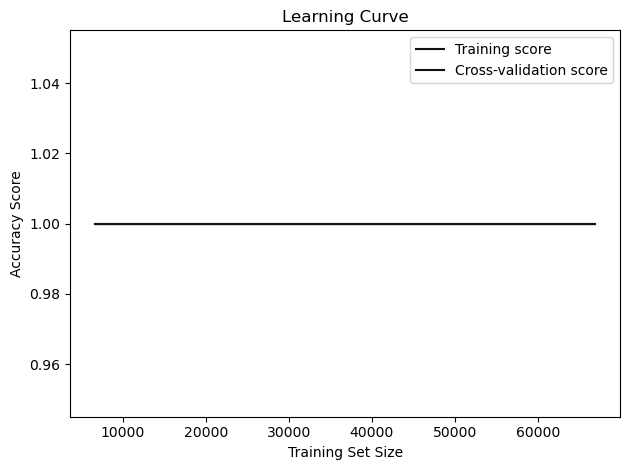

In [19]:
# Compute learning curve
train_sizes, train_scores, test_scores = learning_curve(clf, X_train, y_train, cv=5)

# Compute means and standard deviations of training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Compute means and standard deviations of test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Draw lines
plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
plt.plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")

# Draw bands
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

# Create plot
plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

In [20]:
print("Train Mean:", train_mean)
print("Train Std:", train_std)

Train Mean: [1. 1. 1. 1. 1.]
Train Std: [0. 0. 0. 0. 0.]
